In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sn
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

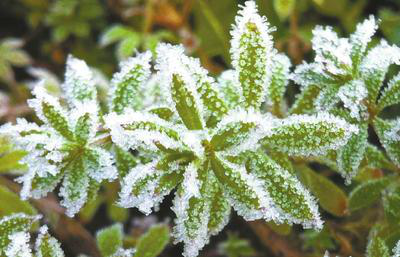

In [3]:
# Open one image from the dataset
path = 'dataset'
with Image.open('dataset/frost/3600.jpg') as img:
    display(img)

In [4]:
# Create ImageFolder Dataset
dataset = datasets.ImageFolder(path, transform=None)
dataset

Dataset ImageFolder
    Number of datapoints: 6862
    Root location: dataset

In [5]:
classes = dataset.classes
print(classes)
print("\t")
print("Number of classes:", len(classes))

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Number of classes: 11


## Split dataset into train, validation and test sets

In [6]:
# Split dataset into train and test
train_size_old = int(0.85 * len(dataset))
test_size = len(dataset) - train_size_old
train_data_old, test_data = torch.utils.data.random_split(dataset, [train_size_old, test_size])

# Split dataset to train and validation
train_size = int(0.85 * len(train_data_old))
validation_size = len(train_data_old) - train_size

train_data, validation_data = torch.utils.data.random_split(train_data_old, [train_size, validation_size])

## Define transforms for each set

In [7]:
# Define the normalization values for mean and standard deviation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Apply transformation mechanism for each set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5,contrast=0.3,saturation=0.2,hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_data.dataset.transform = train_transform

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
validation_data.dataset.transform = val_transform

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_data.dataset.transform = test_transform

## Create data loaders for each set of data

In [8]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

print("Training images available:", len(train_data))
print("\t")
print("Validation images available:", len(validation_data))
print("\t")
print("Testing images available:", len(test_data))

Training images available: 4957
	
Validation images available: 875
	
Testing images available: 1030


In [9]:
# Show one tensor from train data

train_data[0]

(tensor([[[ 0.2796, -0.2171, -0.6623,  ...,  0.3138,  0.5707,  0.9132],
          [ 0.3823,  0.2967, -0.3198,  ...,  0.3138,  0.7762,  0.9817],
          [ 0.1597,  0.5022,  0.0056,  ...,  0.7077,  0.9474,  0.9474],
          ...,
          [-0.4054, -0.5767, -0.4397,  ..., -0.1999, -0.1999, -0.1657],
          [-0.3883, -0.5253, -0.6281,  ..., -0.3027, -0.2513, -0.2171],
          [-1.0904, -0.9020, -0.9020,  ..., -0.4397, -0.1828, -0.1486]],
 
         [[ 0.3803, -0.0924, -0.5301,  ...,  0.5728,  0.8704,  1.2206],
          [ 0.5203,  0.4503, -0.1800,  ...,  0.5903,  1.0805,  1.2906],
          [ 0.3452,  0.6779,  0.1877,  ...,  0.9930,  1.2556,  1.2731],
          ...,
          [-0.1099, -0.2850, -0.1625,  ..., -0.1625, -0.1625, -0.1275],
          [-0.0224, -0.1625, -0.2675,  ..., -0.3375, -0.3025, -0.2675],
          [-0.7402, -0.5476, -0.5476,  ..., -0.4776, -0.2325, -0.1975]],
 
         [[ 1.2282,  0.6182,  0.0082,  ...,  0.7751,  1.2457,  1.5942],
          [ 1.2282,  1.0539,

Class Indexes: [ 8  6  9  2  1  0  8  9  9  2  3  3  6  1  8  8  8  9  9  6  8  9  3  5
  7 10  2  5  0  0  9  9]
	
Sample image size: torch.Size([3, 224, 224])


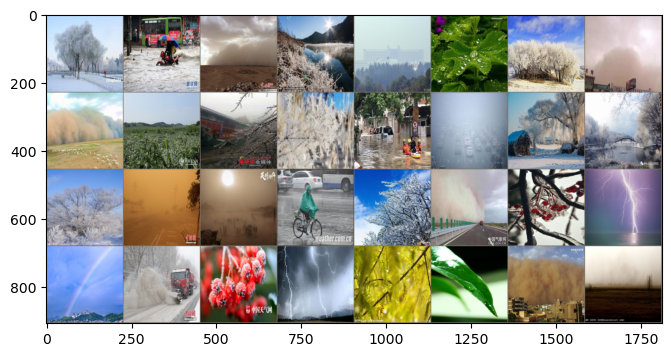

In [10]:
# Grab the first batch of 32 images

for images, labels in train_loader: 
    break

# Print the labels
print('Class Indexes:', labels.numpy())
print("\t")

im = make_grid(images, nrow=8)

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Check one image shape
print("Sample image size:", images[10].shape)

## Define the Convolutional Network (model)

In [11]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(10, 13, kernel_size=3, stride=1, padding=1)

        # Activation layer
        self.relu = nn.ReLU()

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(13 * 28 * 28, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 11)  # 11 classes for output
        
        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Output layer
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        # Apply dropout after the first fully connected layer, 
        # since it has the most parameters and is more prone to overfitting
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        x = self.softmax(x)

        return x
    

# (224/2/2/2) = we divided 224 by the number of conv layers by calling pooling layers,
# which leaves us at 28 pixels per side

In [12]:
# Instantiate the model, define loss and optimization functions

CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(CNNmodel.parameters(), lr=0.001)
print(CNNmodel)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(10, 13, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10192, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=11, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)


In [13]:
# Looking at the trainable parameters
# sum of waits in whole CNN model

def count_parameters(model):
    print("Sum of waits of the model:")
    print("\t")
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
    
count_parameters(CNNmodel)

Sum of waits of the model:
	
     135
       5
     450
      10
    1170
      13
 2038400
     200
   20000
     100
    1100
      11
________
 2061594


## Train the model

In [42]:
start_time = time.time()
epochs = 11

train_losses = []
train_correct = []
validation_losses = []
validation_correct = []

for epoch in range(epochs):
    train_corr = 0
    validation_corr = 0
    
    # Run the training batches
    for batch, (x_train, y_train) in enumerate(train_loader):

        # Apply the model for training
        outputs = CNNmodel(x_train)
        loss = criterion(outputs, y_train)
 
        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1]
        train_corr += (predicted == y_train).sum()
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss)
    train_correct.append(train_corr)
    
    # Print each epoch results
    print(" Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3), 
          "Train accuracy:", round(train_corr.item() * 100 / (batch * 32), 3), "%")


    
    
    # Run the validation batches
    CNNmodel.eval()
    
    with torch.no_grad():
        for batch, (x_validation, y_validation) in enumerate(validation_loader):
            
            # Apply the model for validation
            outputs = CNNmodel(x_validation)
            loss = criterion(outputs, y_validation)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1] 
            validation_corr += (predicted == y_validation).sum()
            
    validation_losses.append(loss)
    validation_correct.append(validation_corr)
    
    # Print each epoch results
    print(" Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
          "Validation accuracy:", round(validation_corr.item() * 100 / (batch * 64), 3), "%")
    print("\t")
    
    
print("\n")
print("Duration:", round(time.time() - start_time, 1), "seconds")

 Epoch: 1 Train loss: 2.289 Train accuracy: 32.65 %
 Epoch: 1 Validation loss: 2.117 Validation accuracy: 39.183 %
	
 Epoch: 2 Train loss: 2.108 Train accuracy: 45.576 %
 Epoch: 2 Validation loss: 2.149 Validation accuracy: 47.957 %
	
 Epoch: 3 Train loss: 1.879 Train accuracy: 49.756 %
 Epoch: 3 Validation loss: 2.096 Validation accuracy: 54.327 %
	
 Epoch: 4 Train loss: 1.873 Train accuracy: 53.815 %
 Epoch: 4 Validation loss: 1.983 Validation accuracy: 56.49 %
	
 Epoch: 5 Train loss: 2.119 Train accuracy: 54.789 %
 Epoch: 5 Validation loss: 1.929 Validation accuracy: 56.37 %
	
 Epoch: 6 Train loss: 1.878 Train accuracy: 55.154 %
 Epoch: 6 Validation loss: 1.858 Validation accuracy: 59.014 %
	
 Epoch: 7 Train loss: 1.896 Train accuracy: 56.412 %
 Epoch: 7 Validation loss: 1.987 Validation accuracy: 59.014 %
	
 Epoch: 8 Train loss: 2.117 Train accuracy: 57.853 %
 Epoch: 8 Validation loss: 2.009 Validation accuracy: 60.096 %
	
 Epoch: 9 Train loss: 2.069 Train accuracy: 58.137 %
 Epoch

## Evaluate model performance

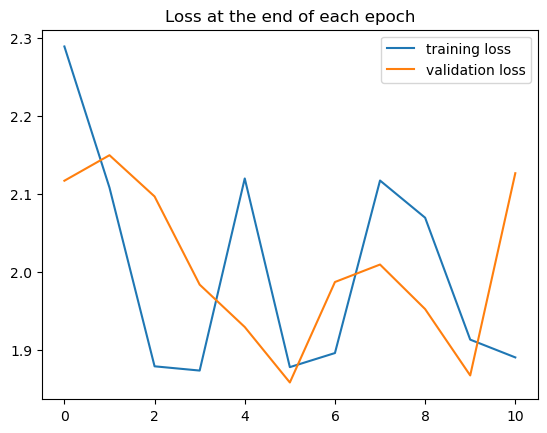

In [43]:
# Plot Losses

plt.plot([t.detach().numpy() for t in train_losses], label='training loss')
plt.plot([t.detach().numpy() for t in validation_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

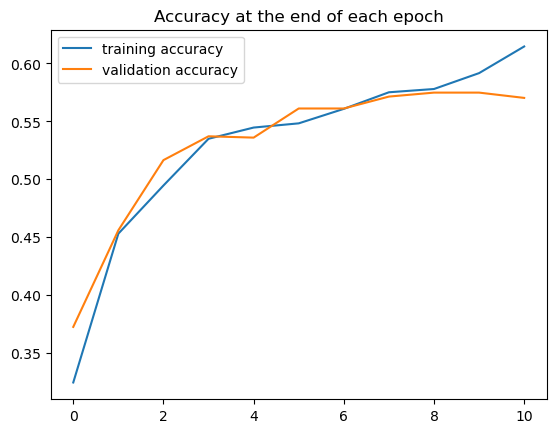

In [44]:
# Plot accuracy

plt.plot([t/4957 for t in train_correct], label='training accuracy')
plt.plot([t/875 for t in validation_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [45]:
# Accuracy of the last epoch for all data

print("Train Correct:", train_correct)
print("Train Accuracy:", round(train_correct[-1].item() * 100 / 4957, 3), "%")

print("\t")

print("Validation Correct:", validation_correct)
print("Validation Accuracy:", round(validation_correct[-1].item() * 100 / 875, 3), "%")

Train Correct: [tensor(1609), tensor(2246), tensor(2452), tensor(2652), tensor(2700), tensor(2718), tensor(2780), tensor(2851), tensor(2865), tensor(2933), tensor(3047)]
Train Accuracy: 61.469 %
	
Validation Correct: [tensor(326), tensor(399), tensor(452), tensor(470), tensor(469), tensor(491), tensor(491), tensor(500), tensor(503), tensor(503), tensor(499)]
Validation Accuracy: 57.029 %


## Test the model

In [46]:
# Test the model
test_losses = []
test_correct = []
test_corr = 0

# Run the test batches
CNNmodel.eval()

with torch.no_grad():
    for batch, (x_test, y_test) in enumerate(test_loader):

        # Apply the model for validation
        outputs = CNNmodel(x_test)
        loss = criterion(outputs, y_test)

        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1] 
        test_corr += (predicted == y_test).sum()

test_losses.append(loss)
test_correct.append(test_corr)

In [47]:
# Evaluate test data

print("Test Correct:", test_correct)
print("Test Accuracy:", round(test_correct[-1].item() * 100 / 1030, 3), "%")

Test Correct: [tensor(610)]
Test Accuracy: 59.223 %


## Confusion Matrix

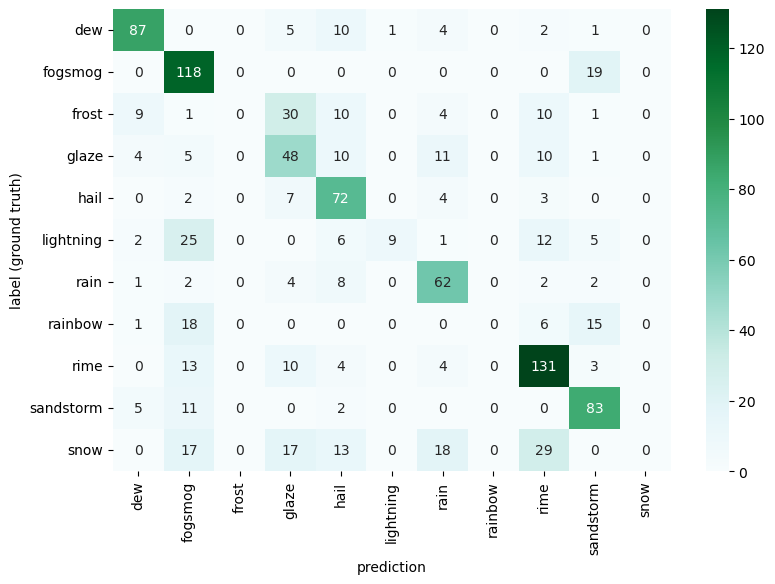

In [48]:
# Create a loader for the entire test set
test_load_all = DataLoader(test_data, batch_size=1030, shuffle=False)

with torch.no_grad():
    correct = 0
    for x_test, y_test in test_load_all:
        outputs = CNNmodel(x_test)
        predicted = torch.max(outputs,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, classes, classes)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Using AlexNet as a pretrained model to evaluate dataset

In [14]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
# We modified the classifier so that we have 11 output features in the last linear layer instead of 1000

AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 11))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [16]:
# These are the TRAINABLE parameters:
count_parameters(AlexNetmodel)

Sum of waits of the model:
	
   23232
      64
  307200
     192
  663552
     384
  884736
     256
  589824
     256
 9437184
    1024
   11264
      11
________
11919179


In [17]:
criterion_AlexNet = nn.CrossEntropyLoss()
optimizer_AlexNet = torch.optim.AdamW(AlexNetmodel.classifier.parameters(), lr=0.001)

In [18]:
# Train data with AlexNet

start_time = time.time()
epochs = 11

train_losses = []
train_correct = []
validation_losses = []
validation_correct = []

for epoch in range(epochs):
    train_corr = 0
    validation_corr = 0
    
    # Run the training batches
    for batch, (x_train, y_train) in enumerate(train_loader):

        # Apply the model for training
        outputs = AlexNetmodel(x_train)
        loss = criterion_AlexNet(outputs, y_train)
 
        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1]
        train_corr += (predicted == y_train).sum()
        
        # Update parameters
        optimizer_AlexNet.zero_grad()
        loss.backward()
        optimizer_AlexNet.step()

    train_losses.append(loss)
    train_correct.append(train_corr)
    
    # Print each epoch results
    print(" Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3), 
          "Train accuracy:", round(train_corr.item() * 100 / (batch * 32), 3), "%")


    
    
    # Run the validation batches
    AlexNetmodel.eval()
    
    with torch.no_grad():
        for batch, (x_validation, y_validation) in enumerate(validation_loader):
            
            # Apply the model for validation
            outputs = AlexNetmodel(x_validation)
            loss = criterion_AlexNet(outputs, y_validation)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1] 
            validation_corr += (predicted == y_validation).sum()
            
    validation_losses.append(loss)
    validation_correct.append(validation_corr)
    
    # Print each epoch results
    print(" Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
          "Validation accuracy:", round(validation_corr.item() * 100 / (batch * 64), 3), "%")
    print("\t")
    
    
print("\n")
print("Duration:", round(time.time() - start_time, 1), "seconds")

 Epoch: 1 Train loss: 0.886 Train accuracy: 75.568 %
 Epoch: 1 Validation loss: 0.383 Validation accuracy: 85.337 %
	
 Epoch: 2 Train loss: 0.079 Train accuracy: 92.248 %
 Epoch: 2 Validation loss: 0.448 Validation accuracy: 86.899 %
	
 Epoch: 3 Train loss: 0.054 Train accuracy: 97.788 %
 Epoch: 3 Validation loss: 0.459 Validation accuracy: 91.346 %
	
 Epoch: 4 Train loss: 0.028 Train accuracy: 99.959 %
 Epoch: 4 Validation loss: 0.766 Validation accuracy: 90.144 %
	
 Epoch: 5 Train loss: 0.004 Train accuracy: 99.959 %
 Epoch: 5 Validation loss: 0.43 Validation accuracy: 91.827 %
	
 Epoch: 6 Train loss: 0.0 Train accuracy: 100.406 %
 Epoch: 6 Validation loss: 0.635 Validation accuracy: 91.947 %
	
 Epoch: 7 Train loss: 0.001 Train accuracy: 100.568 %
 Epoch: 7 Validation loss: 0.915 Validation accuracy: 91.466 %
	
 Epoch: 8 Train loss: 0.0 Train accuracy: 100.548 %
 Epoch: 8 Validation loss: 0.723 Validation accuracy: 91.346 %
	
 Epoch: 9 Train loss: 0.001 Train accuracy: 100.568 %
 Epo

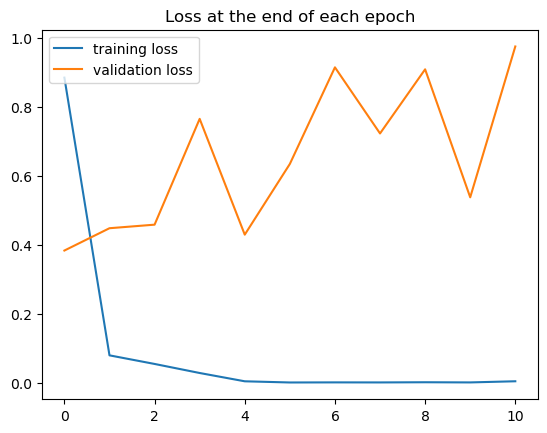

In [19]:
# Plot Losses

plt.plot([t.detach().numpy() for t in train_losses], label='training loss')
plt.plot([t.detach().numpy() for t in validation_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

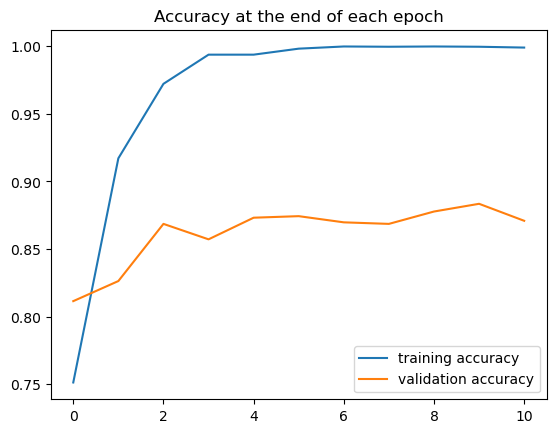

In [20]:
# Plot accuracy

plt.plot([t/4957 for t in train_correct], label='training accuracy')
plt.plot([t/875 for t in validation_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [21]:
# Accuracy of the last epoch for all data

print("Train Correct:", train_correct)
print("Train Accuracy:", round(train_correct[-1].item() * 100 / 4957, 3), "%")

print("\t")

print("Validation Correct:", validation_correct)
print("Validation Accuracy:", round(validation_correct[-1].item() * 100 / 875, 3), "%")

Train Correct: [tensor(3724), tensor(4546), tensor(4819), tensor(4926), tensor(4926), tensor(4948), tensor(4956), tensor(4955), tensor(4956), tensor(4955), tensor(4952)]
Train Accuracy: 99.899 %
	
Validation Correct: [tensor(710), tensor(723), tensor(760), tensor(750), tensor(764), tensor(765), tensor(761), tensor(760), tensor(768), tensor(773), tensor(762)]
Validation Accuracy: 87.086 %


In [22]:
# Test the model
test_losses = []
test_correct = []
test_corr = 0

# Run the test batches
AlexNetmodel.eval()

with torch.no_grad():
    for batch, (x_test, y_test) in enumerate(test_loader):

        # Apply the model for validation
        outputs = AlexNetmodel(x_test)
        loss = criterion_AlexNet(outputs, y_test)

        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1] 
        test_corr += (predicted == y_test).sum()

test_losses.append(loss)
test_correct.append(test_corr)

In [23]:
# Evaluate test data

print("Test Correct:", test_correct)
print("Test Accuracy:", round(test_correct[-1].item() * 100 / 1030, 3), "%")

Test Correct: [tensor(901)]
Test Accuracy: 87.476 %


## Open a custom image and use the models for prediction

Custom image size: torch.Size([3, 224, 224])
	
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Predicted Class Index: 7


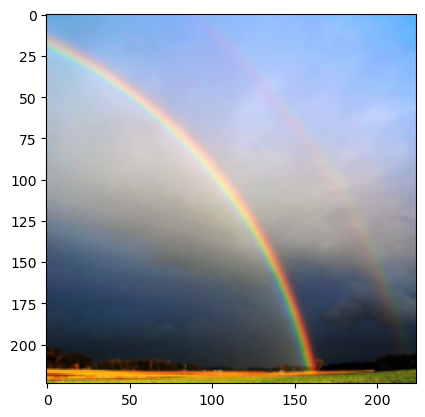

In [29]:
# Custom CNN model

custom_img = Image.open('custom_images/2.jpg')

transform_custom = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

custom_img_t = transform_custom(custom_img)
print("Custom image size:", custom_img_t.shape)
print("\t")

custom_img_n = inv_normalize(custom_img_t)
plt.imshow(np.transpose(custom_img_n.numpy(), (1, 2, 0)));

# CNN Model Prediction:
CNNmodel.eval()
with torch.no_grad():
    custom_pred = CNNmodel(custom_img_t.view(1,3,224,224)).argmax()
    
print("Classes:", classes)
print("\t")
print("Predicted Class Index:", custom_pred.item())

Custom image size: torch.Size([3, 224, 224])
	
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Predicted Class Index: 0


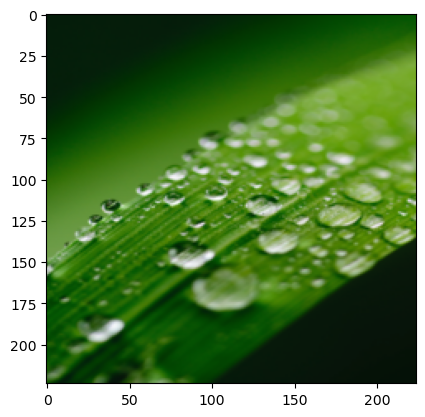

In [36]:
# AlexNet model

custom_img = Image.open('custom_images/2.jpg')

transform_custom = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

custom_img_t = transform_custom(custom_img)
print("Custom image size:", custom_img_t.shape)
print("\t")

custom_img_n = inv_normalize(custom_img_t)
plt.imshow(np.transpose(custom_img_n.numpy(), (1, 2, 0)));

# AlexNet Model Prediction:
AlexNetmodel.eval()
with torch.no_grad():
    custom_pred = AlexNetmodel(custom_img_t.view(1,3,224,224)).argmax()
    
print("Classes:", classes)
print("\t")
print("Predicted Class Index:", custom_pred.item())